In [2]:
import numpy as np
import pandas as pd
import spacy
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [180]:
class Dense(object):
    def __init__(self, out_dim, inp_dim=None, reg=0.001):
        self.W = None
        self.b = np.random.normal(0, 0.2, out_dim)
        self.reg = reg
        self.out_dim = out_dim
        self.inp_dim = inp_dim
        self.inp = None
        self.next = None
        self.momment1 = None
        self.momment2 = None
        self.momment_b1 = np.zeros_like(self.b)
        self.momment_b2 = np.zeros_like(self.b)
        if inp_dim:
            self.W = np.random.normal(0, 1, (self.out_dim, self.inp_dim))
            self.momment1 = np.zeros_like(self.W)
            self.momment2 = np.zeros_like(self.W)

    def __call__(self, inp=None):
        self.inp = inp
        inp.next = self
        self.inp_dim = inp.out_dim
        self.W = np.random.normal(0, 1, (self.out_dim, self.inp_dim))
        self.momment1 = np.zeros_like(self.W)
        self.momment2 = np.zeros_like(self.W)
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' output: ' + str(self.out_dim) + ' input: ' + str(self.inp_dim))

    def forward(self, X, y=None, W=None, b=None):
        self.X = X
        if not W:
            W = self.W
        if not b:
            b = self.b
        out = np.dot(W, X.T).T + b
        return out # logits
    
    def backward(self, dO):
        dW = np.sum(self.X[:, np.newaxis, :] * dO[:, :, np.newaxis], axis=0) + self.reg*self.W
        dX = np.sum(self.W[:, :, np.newaxis] * dO.T[:, np.newaxis, :], axis=0).T
        db = np.sum(dO, axis=0)
        return (dX, dW, db)
    
class Activation(object):
    def __init__(self, func='relu'): # options: relu, softmax_with_cat_cross_entropy (softmax)
        self.act_function = func
        self.next = None

    def __call__(self, inp=None):
        self.inp = inp
        inp.next = self
        self.inp_dim = inp.out_dim
        self.out_dim = self.inp_dim
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' ' + self.act_function + ' output: ' + str(self.out_dim) + ' input: ' + str(self.inp_dim))
    
    def forward(self, X, y=None):
        self.X = X
        self.y = y
        if self.act_function == 'relu':
            out = np.maximum(0, X)
            activations = out
        elif self.act_function == 'softmax':
            exps = np.exp(X - np.max(X, axis=1, keepdims=True))
            activations = exps / np.sum(exps, axis=1, keepdims=True)
            activations = np.where(activations > 1.0e-10, activations, 1.0e-10)
            out = np.mean(-1*np.sum(y * np.log(activations), axis=1))
        self.activations = activations
        return out
    
    def predict(self, X, y=None):
        _ = self.forward(X, y)
        return self.activations
    
    def backward(self, dO=None):
        if self.act_function == 'relu':
            dX = np.where(self.X < 0, 0, 1) * dO
        elif self.act_function == 'softmax':
            dX = self.activations - self.y
        return (dX, None, None)
           


In [181]:
class Optimizer(object): # Adam implementation
    def __init__(self, lr=0.001, b1=0.9, b2=0.999):
        self.b1, self.b2 = b1, b2
        self.eps = 1e-8
        self.t = 1
        self.lr = lr
        self.loss = []

    def run_forward(self, input_layer, X, y):
        layer = input_layer
        out = X
        while (layer):
            # print (layer)
            # print (out.shape)
            out = layer.forward(out, y)
            layer = layer.next
        loss = out
        return loss

    def optimize_step(self, out_layer):
        layer = out_layer 
        t = self.t
        dO = 1  
        lr = self.lr 
        while (layer):
            # print (layer)
            dO, dW, db = layer.backward(dO)
            if dW is not None:
                moment1 = (self.b1 * layer.momment1) + ((1 - self.b1) * dW)
                moment2 = (self.b2 * layer.momment2) + ((1 - self.b2) * dW**2)
                mt1_hat = moment1/(1 - self.b1**t)
                mt2_hat = moment2/(1 - self.b2**t)
                W = layer.W - (lr * mt1_hat/(np.sqrt(mt2_hat) + self.eps))
                layer.W = W
                layer.moment1 = moment1
                layer.moment2 = moment2

                moment_b1 = (self.b1 * layer.momment_b1) + ((1 - self.b1) * db)
                moment_b2 = (self.b2 * layer.momment_b2) + ((1 - self.b2) * db**2)
                mt1_hat = moment_b1/(1 - self.b1**t)
                mt2_hat = moment_b2/(1 - self.b2**t)
                b = layer.b - (lr * mt1_hat/(np.sqrt(mt2_hat) + self.eps))
                layer.b = b
                layer.momment_b1 = moment_b1
                layer.momment_b2 = moment_b2

            self.t = t + 1
            layer = layer.inp
        return self.t

    # def train(self, input_layer, out_layer, X, y, batch_size=None):
    #     patience = 20
    #     loss_tracker = []
    #     patience_remaining = patience
    #     while (patience_remaining > 0):
    #         loss = self.run_forward(input_layer, X, y)
    #         timestep = self.optimize_step(out_layer)
    #         if len(loss_tracker) > 0 and loss > min(loss_tracker):
    #             patience_remaining -= 1
    #         else:
    #             patience_remaining = patience
    #         loss_tracker.append(loss)

    #         print ('iteration:', timestep, 'loss:', loss)

    def train(self, input_layer, out_layer, X, y, batch_size=None, verbose=False):
        patience = 20
        loss_tracker = []
        patience_remaining = patience
        epoch = 0
        if not isinstance(batch_size, int):
            batch_size = X.shape[0]
        print ("Using batch_size of", batch_size)
        while (patience_remaining > 0):
            loss_tracker_epoch = []
            for i in tqdm.tqdm(range(int(np.ceil(X.shape[0]/batch_size))), disable=not verbose):
                up_ind = min(X.shape[0], (i + 1) * batch_size)
                X_batch = X[i * batch_size: up_ind]
                y_batch = y[i * batch_size: up_ind]
                loss = self.run_forward(input_layer, X_batch, y_batch)
                timestep = self.optimize_step(out_layer)
                loss_tracker_epoch.append(loss)
            epoch_loss = np.mean(loss_tracker_epoch)
            epoch += 1
            
            if len(loss_tracker) > 0 and epoch_loss > min(loss_tracker):
                patience_remaining -= 1
            else:
                patience_remaining = patience
            loss_tracker.append(epoch_loss)

            print ('epoch:', epoch, 'loss:', epoch_loss)
    
    def predict(self, input_layer, X, y, batch_size=None):
        out_list = []
        if not isinstance(batch_size, int):
            batch_size = X.shape[0]
        print ("Using batch_size of", batch_size)
        for i in range(int(np.ceil(X.shape[0]/batch_size))):
            up_ind = min(X.shape[0], (i + 1) * batch_size)
            X_batch = X[i * batch_size: up_ind]
            y_batch = y[i * batch_size: up_ind]
            layer = input_layer
            out = X_batch
            while (layer):
                # print (layer)
                # print (out.shape)
                if isinstance(layer, Activation):
                # if isinstance(layer, relu1.__class__):
                    out = layer.predict(out, y_batch)
                else:
                    out = layer.forward(out, y_batch)
                layer = layer.next
            out_list.append(out)
        return np.vstack(out_list)



In [49]:
isinstance(relu2, relu1.__class__)

True

In [3]:
input_layer = Dense(3, inp_dim=4)
relu = Activation(func='relu')(input_layer)
hidden1 = Dense(2)(relu)
out_layer = Activation(func='softmax')(hidden1)

In [4]:
input_layer
out_layer

Activation softmax output: 2 input: 2

In [5]:
optim = Optimizer()

In [6]:
X = np.random.normal(0,2, (1000,4))
y = np.where(X.sum(axis=1) > 0, 1, 0)
y = np.vstack([y, 1-y]).T
# y

In [7]:
out = input_layer.forward(X, y)
print (out.shape)
input_layer.next.forward(out, y)

(1000, 3)


array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 3.11293609, 0.        ],
       [0.        , 2.21398518, 3.16044317],
       [2.03812759, 0.        , 0.        ]])

In [8]:
optim.train(input_layer, out_layer, X, y)

Using batch_size of 1000
epoch: 1 loss: 2.688458388686653
epoch: 2 loss: 2.6817557621008765
epoch: 3 loss: 2.6765548326624917
epoch: 4 loss: 2.6719734717301287
epoch: 5 loss: 2.667739994042726
epoch: 6 loss: 2.663722604094072
epoch: 7 loss: 2.6598490781327433
epoch: 8 loss: 2.656074069229463
epoch: 9 loss: 2.65236843219744
epoch: 10 loss: 2.6486941340868078
epoch: 11 loss: 2.6450357923463836
epoch: 12 loss: 2.6413951709834604
epoch: 13 loss: 2.6377628048368678
epoch: 14 loss: 2.6341311814154715
epoch: 15 loss: 2.6304942426830737
epoch: 16 loss: 2.626847040865273
epoch: 17 loss: 2.6231854938362726
epoch: 18 loss: 2.6195060941766086
epoch: 19 loss: 2.615806018629945
epoch: 20 loss: 2.61208287798317
epoch: 21 loss: 2.608334660097608
epoch: 22 loss: 2.604559668957038
epoch: 23 loss: 2.6007564761892716
epoch: 24 loss: 2.596923881993119
epoch: 25 loss: 2.59306088325887
epoch: 26 loss: 2.589166809536304
epoch: 27 loss: 2.5852410580214835
epoch: 28 loss: 2.5812828425050522
epoch: 29 loss: 2.57

In [9]:
hidden1.forward(relu.forward(input_layer.forward(np.array([[10,10,-100,50]]))))

array([[-544.73687653,  537.05693306]])

In [10]:
display(hidden1.W)
display(input_layer.W)
display(input_layer.forward(np.array([[10,10,100,-50]])))
display(relu.forward(input_layer.forward(np.array([[10,10,100,-50]]))))
hidden1.forward(relu.forward(input_layer.forward(np.array([[10,10,100,-50]]))))

array([[  9.64131023, -11.3004807 ,  11.83826808],
       [ -9.48608141,  11.15141587, -11.20504216]])

array([[ 2.26146161,  2.39437802,  2.46643122,  2.57661835],
       [-1.57808365, -1.56679118, -1.57669307, -1.56495973],
       [ 2.62811695,  2.59904446,  2.57697025,  2.5276572 ]])

array([[ 164.19518227, -110.75809147,  183.64847851]])

array([[164.19518227,   0.        , 183.64847851]])

array([[ 3755.77826827, -3614.51169566]])

In [12]:
X = np.array([1,2,3])
np.sum(np.tile(X, (4,1)), axis=0)
A = np.random.normal(0,1,(5,3))
A

array([[ 0.86848306,  1.26643204,  1.37169069],
       [ 0.04579754,  1.10596105,  0.57764499],
       [ 0.51835422, -0.97051619, -0.99276755],
       [ 0.46160114, -1.07713166,  1.41349292],
       [-0.63529324,  1.07539865,  0.97110773]])

In [20]:
X = np.array([100, 200, 300])
exps = np.exp(X - np.max(X))
exps / np.sum(exps)

array([1.38389653e-87, 3.72007598e-44, 1.00000000e+00])

In [21]:
np.exp(X)/np.sum(np.exp(X))

array([1.38389653e-87, 3.72007598e-44, 1.00000000e+00])

In [19]:
X - np.max(X)

array([-2000, -1000,     0])

In [143]:
np.sum(X, axis=0).shape

(4,)

In [144]:
X.shape

(100, 4)

In [181]:
A = np.array([1,2,3])
B = np.array([[1,2],[3,4],[5,6]])
B

array([[1, 2],
       [3, 4],
       [5, 6]])

In [197]:
B/A[:,None]

array([[1.        , 2.        ],
       [1.5       , 2.        ],
       [1.66666667, 2.        ]])

In [208]:
A = np.random.normal(0,1,(100,2))
A.shape

(100, 2)

In [319]:
X

array([[ 1.22747946,  2.86902839, -4.70108576,  3.70618945],
       [ 0.31652337, -0.2152327 ,  1.0344325 , -2.44062589],
       [ 2.50902626,  2.11491116,  1.66453258, -1.42812386],
       ...,
       [ 0.65188358,  1.51359806, -0.87248501, -1.14562229],
       [ 1.25722504,  2.47242836, -2.0338858 , -1.14701408],
       [ 1.00536655,  0.78447117, -1.4331105 , -5.02476325]])

In [214]:
(X[:,None,:]*A[:,:,None]).sum(axis=0).shape

(2, 4)

In [167]:
(W*nX).shape

(4, 10, 100)

In [166]:
np.sum(nX* W, axis=0).shape

(10, 100)

In [187]:
np.max(X, axis=1, keepdims=True).shape

(100, 1)

In [327]:
A = np.random.normal(0,1,(5,3))
np.maximum(0, A)

array([[0.        , 0.        , 0.37102994],
       [1.27291893, 0.7904717 , 1.49239948],
       [0.81088533, 0.        , 1.61490405],
       [0.44059608, 0.        , 0.98286666],
       [0.73946082, 0.80862822, 0.08511842]])

In [8]:
meta_df_1000 = pd.read_parquet('meta_df_1000_cleaned.parquet')
reviews_df = pd.read_parquet('reviews_df_clean.parquet')

In [9]:
merged_df = pd.merge(meta_df_1000, reviews_df, on='asin', how='inner')
merged_df['category_1'] = merged_df.category.apply(lambda x: x[1])
merged_df['rating'] = merged_df['rating'].astype(float)
merged_df.head()

,category,description,title_x,also_buy,brand,feature,rank,also_view,main_cat,date_x,...,title_y,content,date_y,author,rating,found_helpful,variant,verified_purchase,product,category_1
0,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,One Star,didn't work... If I could've given it zero sta...,2018-06-28,Margie,1.0,0,None,True,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
1,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,Great Bible book light,Gave as a gift to my brother who teaches Sunda...,2017-03-07,Dolphin6411,5.0,0,None,True,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
2,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,I also love this reading light,I also love this reading light. I've had mine...,2014-08-08,Nancy,5.0,1,None,False,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
3,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,Great Reading Light,I am buying the second one of these. I used th...,2011-10-24,James G.,5.0,7,None,False,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
4,"[Electronics, Accessories & Supplies, Audio & ...",Slim Port Adapter for LG G3 Smartphone! MyDP /...,SlimPort sli44532 Adapter for LG G3 Smartphone...,[],SlimPort,This SlimPort/MyDp adapter is specifically des...,[[Electronics > Accessories & Supplies > Audio...,"[B00HFYLR4M, B015DJ4QYI, 9791688974, B00B2HORK...",Computers,,...,Ease of use,Worked well,2022-10-22,Malcolm W. Collins,4.0,0,Color: Black,True,SlimPort sli44532 Adapter for LG G3 Smartphone...,Accessories & Supplies


In [10]:
merged_df = merged_df[merged_df['category_1']\
                    .isin(['Computers & Accessories', 'Camera & Photo', 
                           'Accessories & Supplies', 'Headphones', 'Car & Vehicle Electronics'])]

In [11]:
merged_df['category_1'].value_counts()

Computers & Accessories      2097
Camera & Photo               1413
Accessories & Supplies        901
Headphones                    345
Car & Vehicle Electronics     259
Name: category_1, dtype: int64

In [12]:
nlp = spacy.load('en_core_web_sm')
merged_df['tokens'] = merged_df['content'].apply(lambda x: nlp(x.lower())) 
merged_df.tokens

4                                          (worked, well)
5       (i, had, given, this, item, a, 1, star, and, b...
6       (i, have, an, lg, g3, and, love, the, quality,...
7       (worked, perfectly, ., one, side, goes, into, ...
8       (not, sure, if, this, adapter, is, slowing, do...
                              ...                        
5916    (i, love, this, monitor, !, i, went, through, ...
5917    (i, bought, this, turd, for, my, 2016, macbook...
5918    (i, installed, these, in, my, jeep, ., super, ...
5919    (great, sound, ., my, son, had, them, installe...
5920       (came, as, described, .,  , no, complaints, .)
Name: tokens, Length: 5015, dtype: object

In [13]:
merged_df['tokens'] = merged_df.tokens.apply(lambda x: [w.lemma_ for w in x if not w.is_stop and not w.is_punct and w.lemma_!=' '])

In [14]:
merged_df['tokens'] = merged_df['tokens'].apply(lambda x: ' '.join(x))
merged_df['tokens'].head(10)

4                                                  work
5     give item 1 star bad review not give instructi...
6     lg g3 love quality watch video love transfer l...
7     work perfectly go lg g3 t mobile connect hdmi ...
8     sure adapter slow charger tablet battery drain...
9     item great idea experience device flash work w...
10    work great play movie phone travel sturdy micr...
11    work careful insert completely phone take bit ...
12    packaging description external construction un...
13    say amazon work lg 3smartphone box ship plainl...
Name: tokens, dtype: object

In [15]:
vectorizer = TfidfVectorizer(max_df=0.7)
tokens_vectorized = vectorizer.fit_transform(merged_df['tokens'])
tokens_vectorized

<5015x12814 sparse matrix of type '<class 'numpy.float64'>'
	with 155047 stored elements in Compressed Sparse Row format>

In [89]:
pd.DataFrame(tokens_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).to_csv('tokens_tfidf_vectorized.csv')


In [17]:
tokens_vectorized = pd.read_csv('tokens_tfidf_vectorized.csv')

In [90]:
X_train, X_test, y_train, y_test = train_test_split(tokens_vectorized, merged_df['category_1'], test_size=0.2)
y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

In [91]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4012, 12814), (1003, 12814), (4012, 5), (1003, 5))

In [92]:
input_layer = Dense(128, inp_dim=12814)
relu1 = Activation(func='relu')(input_layer)
hidden1 = Dense(16)(relu1)
relu2 = Activation(func='relu')(hidden1)
hidden2 = Dense(5)(relu2)
out_layer = Activation(func='softmax')(hidden2)

In [93]:
optim = Optimizer()
optim.train(input_layer, out_layer, X_train.toarray(), y_train, batch_size=32)

Using batch_size of 32
epoch: 1 loss: 9.0835497511034
epoch: 2 loss: 5.627354027365108
epoch: 3 loss: 2.8488033601707823
epoch: 4 loss: 1.809236777740621
epoch: 5 loss: 1.4646630405186054
epoch: 6 loss: 1.2984614230235805
epoch: 7 loss: 1.2226737171797792
epoch: 8 loss: 1.2078442738719763
epoch: 9 loss: 1.2040492051503908
epoch: 10 loss: 1.2071564080118804
epoch: 11 loss: 1.1961149257665502
epoch: 12 loss: 1.1820999220037356
epoch: 13 loss: 1.1654196096438798
epoch: 14 loss: 1.1482253941581655
epoch: 15 loss: 1.1354075124837841
epoch: 16 loss: 1.1272917021142663
epoch: 17 loss: 1.1250713103553833
epoch: 18 loss: 1.1246932546698154
epoch: 19 loss: 1.1236191247953566
epoch: 20 loss: 1.1178958371945111
epoch: 21 loss: 1.114463972307903
epoch: 22 loss: 1.110737754882579
epoch: 23 loss: 1.1119677393105127
epoch: 24 loss: 1.1131126613212692
epoch: 25 loss: 1.1132708806015106
epoch: 26 loss: 1.113328857357208
epoch: 27 loss: 1.112992146617963
epoch: 28 loss: 1.112667947142416
epoch: 29 loss: 

In [53]:
np.argmax(hidden2.forward(relu2.forward(hidden1.forward(relu1.forward(input_layer.forward(X_test[:16].toarray(), y_test[:16]))))), axis=1)

array([3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3])

In [94]:
batch_size = 64
X = X_test
y = y_test
out_list = []
if not isinstance(batch_size, int):
    batch_size = X.shape[0]
print ("Using batch_size of", batch_size)
for i in range(int(np.ceil(X.shape[0]/batch_size))):
    up_ind = min(X.shape[0], (i + 1) * batch_size)
    X_batch = X[i * batch_size: up_ind]
    y_batch = y[i * batch_size: up_ind]
    out = hidden2.forward(relu2.forward(hidden1.forward(relu1.forward(input_layer.forward(X_batch.toarray(), y_batch)))))
    out_list.append(out)

Using batch_size of 64


In [95]:
y_preds = np.argmax(np.vstack(out_list),axis=1)
y_preds.shape

(1003,)

In [96]:
np.argmax(y_test, axis=1).shape

(1003,)

In [100]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
accuracy_score(np.argmax(y_test, axis=1), y_preds)

0.5862412761714856

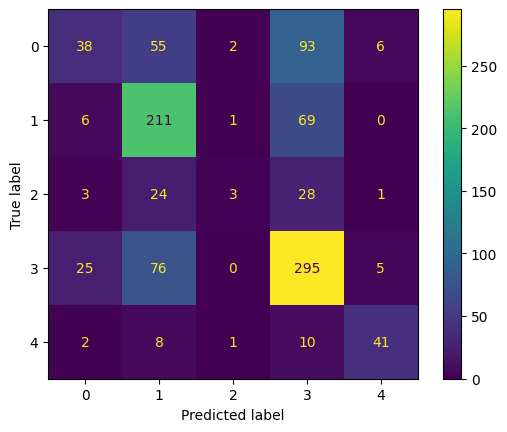

In [103]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1), y_preds)).plot()

In [102]:
print (classification_report(np.argmax(y_test, axis=1), y_preds))

              precision    recall  f1-score   support

           0       0.51      0.20      0.28       194
           1       0.56      0.74      0.64       287
           2       0.43      0.05      0.09        59
           3       0.60      0.74      0.66       401
           4       0.77      0.66      0.71        62

    accuracy                           0.59      1003
   macro avg       0.58      0.48      0.48      1003
weighted avg       0.57      0.59      0.55      1003



In [110]:
pd.value_counts(merged_df.rating)

5.0    2561
4.0    1150
1.0     499
3.0     490
2.0     315
Name: rating, dtype: int64

In [111]:
merged_df['rating_cat'] = np.where(merged_df['rating']==5, 'high', np.where(merged_df['rating']==4, 'moderate', 'low'))
merged_df['rating_cat']

4       moderate
5           high
6            low
7           high
8            low
          ...   
5916        high
5917         low
5918        high
5919        high
5920        high
Name: rating_cat, Length: 5015, dtype: object

In [118]:
merged_df[merged_df.rating == 5.0]['rating_cat'].value_counts()

high    2561
Name: rating_cat, dtype: int64

In [119]:
pd.get_dummies(merged_df['rating_cat'])

,high,low,moderate
4,0,0,1
5,1,0,0
6,0,1,0
7,1,0,0
8,0,1,0
...,...,...,...
5916,1,0,0
5917,0,1,0
5918,1,0,0
5919,1,0,0


In [122]:
y = pd.get_dummies(merged_df['rating_cat']).reindex(columns=['high', 'moderate', 'low']).to_numpy()
y

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(tokens_vectorized, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4012, 12814), (1003, 12814), (4012, 3), (1003, 3))

In [124]:
input_layer = Dense(128, inp_dim=12814)
relu1 = Activation(func='relu')(input_layer)
hidden1 = Dense(16)(relu1)
relu2 = Activation(func='relu')(hidden1)
hidden2 = Dense(3)(relu2)
out_layer = Activation(func='softmax')(hidden2)

In [125]:
optim = Optimizer()
optim.train(input_layer, out_layer, X_train.toarray(), y_train, batch_size=32)

Using batch_size of 32
epoch: 1 loss: 8.321518061011657
epoch: 2 loss: 5.445246394971871
epoch: 3 loss: 2.9642780009617797
epoch: 4 loss: 1.6403480777138448
epoch: 5 loss: 1.2185448995979151
epoch: 6 loss: 1.089915616461989
epoch: 7 loss: 1.0319098705932401
epoch: 8 loss: 1.0110345063685315
epoch: 9 loss: 0.999048640271273
epoch: 10 loss: 0.9964210941468851
epoch: 11 loss: 0.9925904100452937
epoch: 12 loss: 0.9830922104019385
epoch: 13 loss: 0.9732794137669527
epoch: 14 loss: 0.9619556789601377
epoch: 15 loss: 0.9537778661450566
epoch: 16 loss: 0.9492270364884011
epoch: 17 loss: 0.9467762731744287
epoch: 18 loss: 0.94419347721398
epoch: 19 loss: 0.9433130605452763
epoch: 20 loss: 0.9432685568841744
epoch: 21 loss: 0.9415594133187318
epoch: 22 loss: 0.9381847718751705
epoch: 23 loss: 0.9382918294530043
epoch: 24 loss: 0.9384016664814158
epoch: 25 loss: 0.9386757793228967
epoch: 26 loss: 0.9414653406137853
epoch: 27 loss: 0.9396999530710282
epoch: 28 loss: 0.9391002380044426
epoch: 29 lo

In [ ]:
optim.train(input_layer, out_layer, X_train.toarray(), y_train, batch_size=32)

In [154]:
y_preds = optim.predict(input_layer, X_test.toarray(), y_test, batch_size=32)
print (y_preds.shape)
y_preds = np.argmax(y_preds ,axis=1)
y_preds.shape

Using batch_size of 32
(1003, 3)


(1003,)

In [155]:
accuracy_score(np.argmax(y_test, axis=1), y_preds)

0.5653040877367896

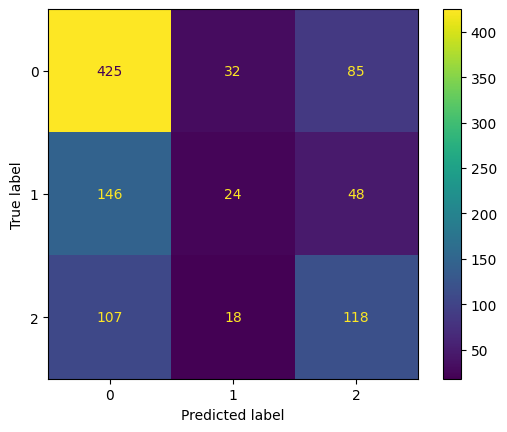

In [156]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1), y_preds)).plot()

In [157]:
y_preds = optim.predict(input_layer, X_train.toarray(), y_train, batch_size=32)
print (y_preds.shape)
y_preds = np.argmax(y_preds ,axis=1)
y_preds.shape

Using batch_size of 32
(4012, 3)


(4012,)

In [158]:
accuracy_score(np.argmax(y_train, axis=1), y_preds)

0.5914755732801595

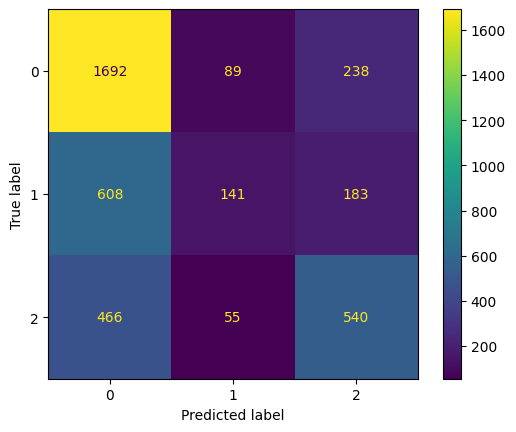

In [159]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_train, axis=1), y_preds)).plot()

In [153]:
optim = Optimizer(lr=0.0004)
optim.train(input_layer, out_layer, X_train.toarray(), y_train, batch_size=32)

Using batch_size of 32
epoch: 1 loss: 0.9327837967434333
epoch: 2 loss: 0.933836795563102
epoch: 3 loss: 0.9352101328985902
epoch: 4 loss: 0.9365502784612195
epoch: 5 loss: 0.938216720672408
epoch: 6 loss: 0.939886707686169
epoch: 7 loss: 0.9414413421246477
epoch: 8 loss: 0.942680490290674
epoch: 9 loss: 0.9435996503796444
epoch: 10 loss: 0.9460401651619511
epoch: 11 loss: 0.947283552523657
epoch: 12 loss: 0.9481720645766869
epoch: 13 loss: 0.9489364706776379
epoch: 14 loss: 0.9504109706212313
epoch: 15 loss: 0.9520940060937277
epoch: 16 loss: 0.9526065497787952
epoch: 17 loss: 0.9530294661925754
epoch: 18 loss: 0.9541115944538482
epoch: 19 loss: 0.9554648149277859
epoch: 20 loss: 0.9566276575125531
epoch: 21 loss: 0.9569778683704788


In [185]:
input_layer = Dense(128, inp_dim=12814, reg=0.00005)
relu1 = Activation(func='relu')(input_layer)
hidden1 = Dense(64, reg=0.00005)(relu1)
relu2 = Activation(func='relu')(hidden1)
hidden2 = Dense(3, reg=0.00005)(relu2)
out_layer = Activation(func='softmax')(hidden2)

In [186]:
optim = Optimizer()
optim.train(input_layer, out_layer, X_train.toarray(), y_train, batch_size=32)

Using batch_size of 32
epoch: 1 loss: 11.440429345311689
epoch: 2 loss: 10.064108625338351
epoch: 3 loss: 7.971732681922244
epoch: 4 loss: 5.891922766067377
epoch: 5 loss: 4.173541345119224
epoch: 6 loss: 2.939616230396146
epoch: 7 loss: 2.212795159392059
epoch: 8 loss: 1.7697670765793012
epoch: 9 loss: 1.475265443834406
epoch: 10 loss: 1.297153284572833
epoch: 11 loss: 1.1842313177081667
epoch: 12 loss: 1.1069444421408619
epoch: 13 loss: 1.04939591156342
epoch: 14 loss: 1.0188296979464104
epoch: 15 loss: 0.998542977740094
epoch: 16 loss: 0.9838169029149025
epoch: 17 loss: 0.9712143599914912
epoch: 18 loss: 0.9677486734221873
epoch: 19 loss: 0.9658495809905815
epoch: 20 loss: 0.9645841260917478
epoch: 21 loss: 0.9597764566225916
epoch: 22 loss: 0.9573131597857798
epoch: 23 loss: 0.9530185493218676
epoch: 24 loss: 0.9505969320604111
epoch: 25 loss: 0.9492976898997754
epoch: 26 loss: 0.9474826340299851
epoch: 27 loss: 0.9476386087193425
epoch: 28 loss: 0.9509519311801921
epoch: 29 loss: 

In [197]:
y_preds = optim.predict(input_layer, X_test.toarray(), y_test, batch_size=32)
print (y_preds.shape)
y_preds = np.argmax(y_preds ,axis=1)
y_preds.shape

Using batch_size of 32
(1003, 3)


(1003,)

In [198]:
accuracy_score(np.argmax(y_test, axis=1), y_preds)

0.5613160518444666

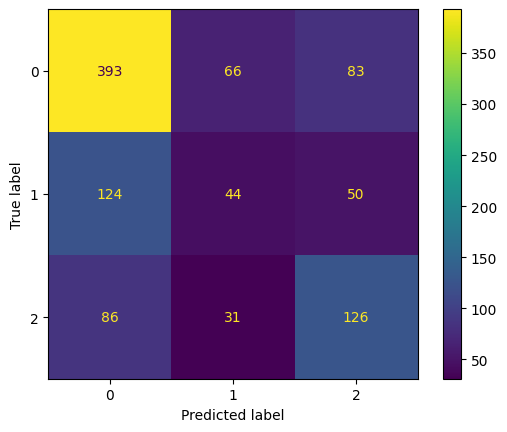

In [199]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1), y_preds)).plot()

In [194]:
y_preds = optim.predict(input_layer, X_train.toarray(), y_train, batch_size=32)
print (y_preds.shape)
y_preds = np.argmax(y_preds ,axis=1)
y_preds.shape

Using batch_size of 32
(4012, 3)


(4012,)

In [195]:
accuracy_score(np.argmax(y_train, axis=1), y_preds)

0.6360917248255235

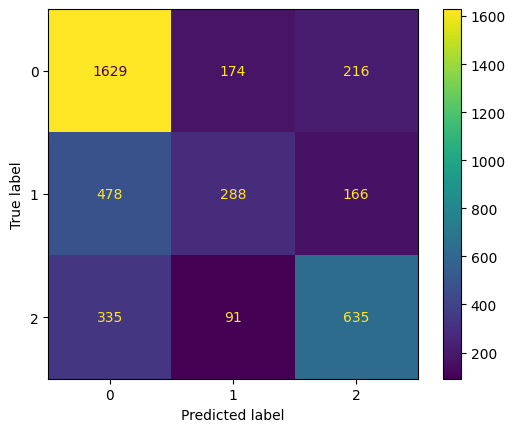

In [196]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_train, axis=1), y_preds)).plot()

In [193]:
optim = Optimizer(lr=0.0004)
optim.train(input_layer, out_layer, X_train.toarray(), y_train, batch_size=32)

Using batch_size of 32
epoch: 1 loss: 0.9051638383096022
epoch: 2 loss: 0.9044988401631517
epoch: 3 loss: 0.9049319655261865
epoch: 4 loss: 0.905092776275469
epoch: 5 loss: 0.9043460841194689
epoch: 6 loss: 0.9040711387333723
epoch: 7 loss: 0.904534672904988
epoch: 8 loss: 0.9050790112268547
epoch: 9 loss: 0.90514288963844
epoch: 10 loss: 0.9048616058994841
epoch: 11 loss: 0.9045353225381295
epoch: 12 loss: 0.9034793496815324
epoch: 13 loss: 0.9031951806465164
epoch: 14 loss: 0.9045506405160262
epoch: 15 loss: 0.9044715735863773
epoch: 16 loss: 0.9062937816535438
epoch: 17 loss: 0.9068722987159011
epoch: 18 loss: 0.9085824650095546
epoch: 19 loss: 0.9099026308623448
epoch: 20 loss: 0.910466562263091
epoch: 21 loss: 0.9109443494736381
epoch: 22 loss: 0.9103988891735877
epoch: 23 loss: 0.9100608332309993
epoch: 24 loss: 0.9098952682011808
epoch: 25 loss: 0.9099247502591502
epoch: 26 loss: 0.9106795675947351
epoch: 27 loss: 0.9114991234903344
epoch: 28 loss: 0.9121330327776791
epoch: 29 l

In [17]:
merged_df.columns

Index(['category', 'description', 'title_x', 'also_buy', 'brand', 'feature',
       'rank', 'also_view', 'main_cat', 'date_x', 'price', 'asin', 'title_y',
       'content', 'date_y', 'author', 'rating', 'found_helpful', 'variant',
       'verified_purchase', 'product', 'category_1', 'tokens'],
      dtype='object')

In [24]:
import statsmodels.api as sm
merged_df_lr = merged_df[['price', 'found_helpful', 'verified_purchase', 'rating']].dropna()
print (merged_df_lr.shape)
merged_df_lr['verified_purchase'] = merged_df_lr['verified_purchase'].astype(float)
lr_x = sm.add_constant(merged_df_lr[['price', 'found_helpful', 'verified_purchase']])
lr_x


(2723, 4)


,const,price,found_helpful,verified_purchase
4,1.0,1.54,0,1.0
5,1.0,1.54,10,1.0
6,1.0,1.54,1,1.0
7,1.0,1.54,7,1.0
8,1.0,1.54,0,1.0
...,...,...,...,...
5857,1.0,4.88,1,1.0
5858,1.0,4.88,2,1.0
5859,1.0,4.88,0,1.0
5860,1.0,29.95,0,1.0


In [25]:
mod = sm.OLS(merged_df_lr['rating'], lr_x)
res = mod.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     13.14
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.61e-08
Time:                        14:32:57   Log-Likelihood:                -4285.1
No. Observations:                2723   AIC:                             8578.
Df Residuals:                    2719   BIC:                             8602.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.4343      0.11

<AxesSubplot: xlabel='rating', ylabel='price'>

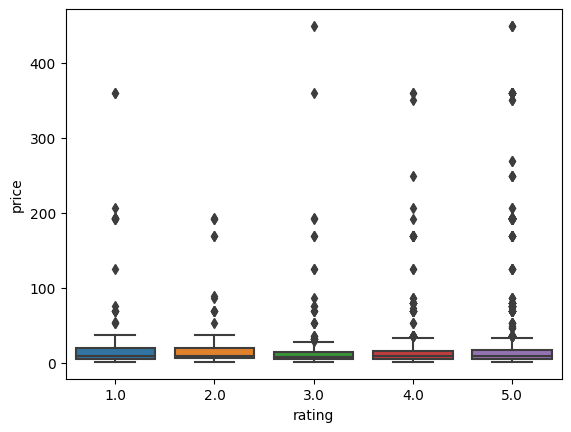

In [175]:
import seaborn as sns
sns.boxplot(x = 'rating', y='price', data=merged_df_lr)

In [ ]:
## could not save the best model in training, instaead had to use the last epoch
## Could have reducing learning rates at plateaus
## could not use the GPU to try out several combinations of layer units and larger neural nets (more units, more layers)
## could not use dropouts
## could not weigh classes
## oversampling